# Trabalho 2 - Unidade 2: A* + MST para Análise de Redes Viárias


**Disciplina:** Análise e Estrutura de Dados 2

**Professor:** Ivanovich Medeiros Dantas da Silva

**Aluno(s):** Ariadne Evangelista e Arthur Queiroz

## 1. Introdução

Este trabalho analisa a conectividade entre Pontos de Interesse (POIs) em cidades brasileiras, estimando a extensão mínima de vias necessária para interligá-los. Utilizamos uma metodologia que combina modelagem da rede viária com OSMnx e algoritmos de grafos: A* para caminhos mais curtos entre POIs e Kruskal para cálculo da Árvore Geradora Mínima (MST).

O estudo foi realizado em oito cidades - Natal, Salvador, Belo Horizonte, Florianópolis, Goiânia, São Luís, Guarulhos e João Pessoa - utilizando estabelecimentos bancários como POIs. A abordagem envolve mapear POIs para nós da rede viária, calcular rotas ótimas com A*, construir um grafo completo com distâncias obtidas e aplicar Kruskal para encontrar a MST que conecta todos os pontos com custo mínimo.

A análise comparativa dos resultados, incluindo comprimento total da MST e métricas de eficiência por POI, revela padrões de conectividade urbana influenciados por fatores geográficos e de planejamento. As visualizações das rotas da MST complementam a análise quantitativa, oferecendo insights sobre a infraestrutura necessária para conectar serviços essenciais em diferentes contextos urbanos.

## 2. Metodologia

Neste estudo, os Pontos de Interesse (POIs) selecionados foram as agências bancárias (amenity: bank). A escolha se justifica pela ampla distribuição desses serviços em áreas urbanas e sua relevância para o cotidiano da população, exigindo boa conectividade territorial. Esta abordagem oferece uma perspectiva sobre a conectividade urbana centrada em serviços financeiros de acesso essencial.

A seleção das oito cidades analisadas buscou representar a diversidade geográfica e urbanística brasileira, incluindo capitais regionais e cidades de médio porte com características distintas:

* Natal (RN): Capital nordestina com urbanização consolidada e influência litorânea
Salvador (BA): Metrópole nordestina com topografia acidentada e grande extensão territorial

* Belo Horizonte (MG): Capital planejada em região montanhosa com malha viária radial

* Florianópolis (SC): Cidade insular com desafios de conectividade entre ilha e continente

* Goiânia (GO): Capital planejada do Centro-Oeste com traçado moderno

* São Luís (MA): Cidade histórica do Nordeste com desenvolvimento costeiro

* Guarulhos (SP): Município metropolitano com intensa conurbação na Grande São Paulo

* João Pessoa (PB): Capital nordestina de médio porte com desenvolvimento litorâneo

A metodologia consistiu em quatro etapas principais: primeiramente, a obtenção do grafo viário de cada cidade via OSMnx e sua projeção para sistema métrico; em seguida, o mapeamento dos POIs para os nós mais próximos na rede viária; posteriormente, o cálculo das rotas ótimas entre todos os pares de POIs usando o algoritmo A* com heurística euclidiana; e finalmente, a construção de um grafo completo com as distâncias obtidas e aplicação do algoritmo de Kruskal para encontrar a Árvore Geradora Mínima.

A análise comparativa considerou o comprimento total da MST, a média de metros necessários por POI e por aresta da MST, permitindo avaliar a eficiência da conectividade em cada contexto urbano. As visualizações das rotas que compõem a MST em cada cidade complementam a análise quantitativa, revelando padrões espaciais de distribuição dos serviços bancários e da infraestrutura viária.

## 3. Modelagem e Pré-processamento

A modelagem e pré-processamento dos dados foram realizados em quatro etapas principais, utilizando Python e bibliotecas especializadas em análise de redes urbanas. Na primeira etapa, foram importadas as bibliotecas essenciais: OSMnx para obtenção e manipulação de grafos viários, NetworkX para algoritmos de grafos, Matplotlib para visualização, Pandas para análise de dados e NumPy para cálculos numéricos. A supressão de avisos garantiu a limpeza do output durante a execução.

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Bibliotecas
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

Na segunda etapa, definiram-se os parâmetros do estudo, incluindo as oito cidades brasileiras selecionadas para análise e o tipo de ponto de interesse (POI) como estabelecimentos bancários (amenity: bank). Esta configuração inicial estabeleceu a base comparativa entre cidades com características urbanísticas distintas, desde metrópoles como Salvador e Belo Horizonte até cidades de médio porte como João Pessoa e Guarulhos.


In [ ]:
warnings.filterwarnings('ignore')

# Configurações iniciais - Parâmetro de POI e Cidades
cidades = [
    "Natal, Rio Grande do Norte, Brazil",
    "Belo Horizonte, Minas Gerais, Brazil",
    "Florianópolis, Santa Catarina, Brazil",
    "Salvador, Bahia, Brazil",
    "João Pessoa, Paraíba, Brazil",
    "Goiânia, Goiás, Brazil",
    "São Luís, Maranhão, Brazil",
    "Guarulhos, São Paulo, Brazil"
]
tipo_poi = {'amenity': 'bank'}

resultados_cidades = []

A terceira etapa consistiu na implementação de uma função auxiliar para conversão de grafos direcionados (MultiDiGraph) em grafos não direcionados (MultiGraph), preservando todos os atributos de nós e arestas. Esta conversão foi necessária para adequar a estrutura de dados aos algoritmos subsequentes, mantendo a integridade das informações da rede viária.

In [ ]:
# Função auxiliar
def to_undirected_multigraph(G):
    H = nx.MultiGraph()
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)
    for u, v, data in G.edges(data=True):
        H.add_edge(u, v, **data)
    H.graph.update(G.graph)
    return H

A quarta e crucial etapa envolveu o desenvolvimento de uma função corrigida para mapeamento de POIs aos nós da rede viária. Diferentemente da abordagem convencional que processa listas completas de coordenadas, esta função processa cada POI individualmente, garantindo que cada ponto de interesse seja corretamente associado ao nó mais próximo no grafo. Esta correção foi fundamental para resolver o problema inicial de múltiplos POIs sendo atribuídos ao mesmo nó, assegurando a precisão do mapeamento espacial necessário para os cálculos subsequentes de conectividade.

In [ ]:
# Função CORRIGIDA para encontrar nós
def encontrar_nos_unicos(G, poi_points):
    """Encontra nós únicos para cada POI individualmente"""
    nos_unicos = set()

    for lat, lon in poi_points:
        try:
            # Processar CADA POI individualmente
            node = ox.distance.nearest_nodes(G, X=[lon], Y=[lat])[0]
            nos_unicos.add(node)
        except Exception as e:
            continue

    return list(nos_unicos)

## 4. Processamento e Cálculo da MST

In [ ]:
# Processar cada cidade
for cidade in cidades:
    print(f"Processando: {cidade}")

    try:
        # 1. Grafo viário da cidade
        G = ox.graph_from_place(cidade, network_type='drive')
        G_proj = ox.project_graph(G)
        G_undirected = to_undirected_multigraph(G_proj)

        # 2. Obter POIs
        pois = ox.features.features_from_place(cidade, tags=tipo_poi)

        if pois.empty:
            print(f"  - Nenhum POI encontrado")
            continue

        # Extrair pontos dos POIs
        poi_points = []
        for idx, row in pois.iterrows():
            if row.geometry.geom_type == 'Point':
                poi_points.append((row.geometry.y, row.geometry.x))
            else:
                poi_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

        print(f"  - Encontrados {len(poi_points)} POIs")

        # CORREÇÃO: Usar função corrigida para encontrar nós
        poi_nodes_unique = encontrar_nos_unicos(G_undirected, poi_points)

        if len(poi_nodes_unique) < 2:
            print(f"  - POIs insuficientes: {len(poi_nodes_unique)} nós únicos")

            # Tentativa alternativa: usar grafo não projetado
            print("  - Tentando com grafo não projetado...")
            G_undirected_original = to_undirected_multigraph(G)
            poi_nodes_unique = encontrar_nos_unicos(G_undirected_original, poi_points)

            if len(poi_nodes_unique) < 2:
                continue

        print(f"  - {len(poi_nodes_unique)} nós únicos mapeados")

        # 3. Rotas A* entre todos os pares de POIs
        G_completo = nx.Graph()
        rotas_astar = {}
        pares_calculados = 0

        for i in range(len(poi_nodes_unique)):
            for j in range(i+1, len(poi_nodes_unique)):
                try:
                    # Heurística Euclidiana no plano projetado
                    heuristic = lambda u, v: ox.distance.euclidean(
                        G_proj.nodes[u]['y'], G_proj.nodes[u]['x'],
                        G_proj.nodes[v]['y'], G_proj.nodes[v]['x']
                    )

                    rota = nx.astar_path(G_proj, poi_nodes_unique[i], poi_nodes_unique[j],
                                       heuristic=heuristic, weight='length')
                    distancia = nx.astar_path_length(G_proj, poi_nodes_unique[i], poi_nodes_unique[j],
                                                   heuristic=heuristic, weight='length')

                    G_completo.add_edge(poi_nodes_unique[i], poi_nodes_unique[j], weight=distancia)
                    rotas_astar[(poi_nodes_unique[i], poi_nodes_unique[j])] = rota
                    pares_calculados += 1

                except (nx.NetworkXNoPath, KeyError, nx.NodeNotFound):
                    continue

        print(f"  - {pares_calculados} rotas A* calculadas")

        if G_completo.number_of_edges() == 0:
            print(f"  - Nenhuma rota válida encontrada")
            continue

        # 4. Calcular MST sobre grafo completo
        mst_arestas = list(nx.minimum_spanning_edges(G_completo, data=True, algorithm='kruskal'))
        comprimento_mst = sum([d['weight'] for (u, v, d) in mst_arestas])

        # Calcular comprimento real na malha viária
        comprimento_real = 0
        rotas_mst = []

        for u, v, d in mst_arestas:
            if (u, v) in rotas_astar:
                rota = rotas_astar[(u, v)]
                rotas_mst.append(rota)

                # Somar comprimento real da rota
                for k in range(len(rota)-1):
                    arestas = G_proj.get_edge_data(rota[k], rota[k+1])
                    if arestas:
                        for key in arestas:
                            if 'length' in arestas[key]:
                                comprimento_real += arestas[key]['length']

        # Métricas por POI e por aresta
        media_por_poi = comprimento_real / len(poi_nodes_unique) if poi_nodes_unique else 0
        media_por_aresta = comprimento_real / len(mst_arestas) if mst_arestas else 0

        # Armazenar resultados
        resultados_cidades.append({
            'Cidade': cidade,
            'POIs_Encontrados': len(poi_points),
            'POIs_Unicos': len(poi_nodes_unique),
            'MST_km': comprimento_mst / 1000,
            'MST_Real_km': comprimento_real / 1000,
            'Media_por_POI_km': media_por_poi / 1000,
            'Media_por_Aresta_km': media_por_aresta / 1000,
            'Arestas_MST': len(mst_arestas),
            'Rotas_MST': rotas_mst,
            'Grafo': G_proj,
            'Nos_POIs': poi_nodes_unique
        })

        print(f"  - MST: {comprimento_real/1000:.2f} km | Média/POI: {media_por_poi/1000:.2f} km")

    except Exception as e:
        print(f"  - Erro: {e}")
        continue

print(f"\n Processamento concluído: {len(resultados_cidades)} cidades processadas")

Processando: Natal, Rio Grande do Norte, Brazil
  - Encontrados 61 POIs
  - POIs insuficientes: 1 nós únicos
  - Tentando com grafo não projetado...
  - 53 nós únicos mapeados
  - 1378 rotas A* calculadas
  - MST: 43.05 km | Média/POI: 0.81 km
Processando: Belo Horizonte, Minas Gerais, Brazil
  - Encontrados 205 POIs
  - POIs insuficientes: 1 nós únicos
  - Tentando com grafo não projetado...
  - 171 nós únicos mapeados
  - 14535 rotas A* calculadas
  - MST: 133.49 km | Média/POI: 0.78 km
Processando: Florianópolis, Santa Catarina, Brazil
  - Encontrados 73 POIs
  - POIs insuficientes: 1 nós únicos
  - Tentando com grafo não projetado...
  - 63 nós únicos mapeados
  - 1953 rotas A* calculadas
  - MST: 86.33 km | Média/POI: 1.37 km
Processando: Salvador, Bahia, Brazil
  - Encontrados 185 POIs
  - POIs insuficientes: 1 nós únicos
  - Tentando com grafo não projetado...
  - 158 nós únicos mapeados
  - 12284 rotas A* calculadas
  - MST: 155.25 km | Média/POI: 0.98 km
Processando: João Pess

## 5. Resultados: Comparação entre Cidades

In [ ]:
# 5. Comparação entre cidades
if resultados_cidades:
    df_resultados = pd.DataFrame(resultados_cidades)

    print("\n" + "="*80)
    print("COMPARAÇÃO ENTRE CIDADES")
    print("="*80)

    # Tabela comparativa
    print("\nTABELA COMPARATIVA:")
    comparacao = df_resultados[['Cidade', 'POIs_Unicos', 'MST_Real_km', 'Media_por_POI_km', 'Media_por_Aresta_km']].round(2)
    print(comparacao.to_string(index=False))

    # Estatísticas consolidadas
    print(f"\nESTATÍSTICAS GERAIS:")
    print(f"Comprimento médio da MST: {df_resultados['MST_Real_km'].mean():.2f} km")
    print(f"Desvio padrão da MST: {df_resultados['MST_Real_km'].std():.2f} km")
    print(f"Média por POI: {df_resultados['Media_por_POI_km'].mean():.2f} km/POI")
    print(f"Desvio padrão por POI: {df_resultados['Media_por_POI_km'].std():.2f} km/POI")
    print(f"Média por aresta MST: {df_resultados['Media_por_Aresta_km'].mean():.2f} km/aresta")
    print(f"Desvio padrão por aresta: {df_resultados['Media_por_Aresta_km'].std():.2f} km/aresta")

    # Cidade com maior e menor MST
    if len(df_resultados) > 0:
        maior_mst = df_resultados.loc[df_resultados['MST_Real_km'].idxmax()]
        menor_mst = df_resultados.loc[df_resultados['MST_Real_km'].idxmin()]

        print(f"\nEXTREMOS:")
        print(f"Maior MST: {maior_mst['Cidade']} ({maior_mst['MST_Real_km']:.2f} km)")
        print(f"Menor MST: {menor_mst['Cidade']} ({menor_mst['MST_Real_km']:.2f} km)")


COMPARAÇÃO ENTRE CIDADES

TABELA COMPARATIVA:
                               Cidade  POIs_Unicos  MST_Real_km  Media_por_POI_km  Media_por_Aresta_km
   Natal, Rio Grande do Norte, Brazil           53        43.05              0.81                 0.83
 Belo Horizonte, Minas Gerais, Brazil          171       133.49              0.78                 0.79
Florianópolis, Santa Catarina, Brazil           63        86.33              1.37                 1.39
              Salvador, Bahia, Brazil          158       155.25              0.98                 0.99
         João Pessoa, Paraíba, Brazil           50        45.20              0.90                 0.92
               Goiânia, Goiás, Brazil           84        80.60              0.96                 0.97
           São Luís, Maranhão, Brazil           50        64.13              1.28                 1.31
         Guarulhos, São Paulo, Brazil           41        48.12              1.17                 1.20

ESTATÍSTICAS GERAIS:
Comp

In [ ]:
# 5. Comparação entre cidades
if resultados_cidades:
    df_resultados = pd.DataFrame(resultados_cidades)

    print("\n" + "_"*80)
    print("COMPARAÇÃO ENTRE CIDADES")
    print("_"*80)

    # Tabela comparativa
    print("\nTABELA COMPARATIVA:")
    comparacao = df_resultados[['Cidade', 'POIs_Unicos', 'MST_Real_km', 'Media_por_POI_km', 'Media_por_Aresta_km']].round(2)
    print(comparacao.to_string(index=False))

    # Estatísticas consolidadas
    print(f"\nESTATÍSTICAS GERAIS:")
    print(f"Comprimento médio da MST: {df_resultados['MST_Real_km'].mean():.2f} km")
    print(f"Desvio padrão da MST: {df_resultados['MST_Real_km'].std():.2f} km")
    print(f"Média por POI: {df_resultados['Media_por_POI_km'].mean():.2f} km/POI")
    print(f"Desvio padrão por POI: {df_resultados['Media_por_POI_km'].std():.2f} km/POI")
    print(f"Média por aresta MST: {df_resultados['Media_por_Aresta_km'].mean():.2f} km/aresta")
    print(f"Desvio padrão por aresta: {df_resultados['Media_por_Aresta_km'].std():.2f} km/aresta")

    # Cidade com maior e menor MST
    if len(df_resultados) > 0:
        maior_mst = df_resultados.loc[df_resultados['MST_Real_km'].idxmax()]
        menor_mst = df_resultados.loc[df_resultados['MST_Real_km'].idxmin()]

        print(f"\nEXTREMOS:")
        print(f"Maior MST: {maior_mst['Cidade']} ({maior_mst['MST_Real_km']:.2f} km)")
        print(f"Menor MST: {menor_mst['Cidade']} ({menor_mst['MST_Real_km']:.2f} km)")


________________________________________________________________________________
COMPARAÇÃO ENTRE CIDADES
________________________________________________________________________________

TABELA COMPARATIVA:
                               Cidade  POIs_Unicos  MST_Real_km  Media_por_POI_km  Media_por_Aresta_km
   Natal, Rio Grande do Norte, Brazil           53        43.05              0.81                 0.83
 Belo Horizonte, Minas Gerais, Brazil          171       133.49              0.78                 0.79
Florianópolis, Santa Catarina, Brazil           63        86.33              1.37                 1.39
              Salvador, Bahia, Brazil          158       155.25              0.98                 0.99
         João Pessoa, Paraíba, Brazil           50        45.20              0.90                 0.92
               Goiânia, Goiás, Brazil           84        80.60              0.96                 0.97
           São Luís, Maranhão, Brazil           50        64.13       

In [ ]:
warnings.filterwarnings('ignore')

# Configurações para os plots
plt.style.use('default')
figsize = (15, 12)

# Função para plotar o MST de CADA cidade individualmente
def plotar_mst_cidade(resultado):
    """Plota o subgrafo final com as rotas MST para uma cidade específica"""

    cidade_nome = resultado['Cidade']
    G_proj = resultado['Grafo']
    rotas_mst = resultado['Rotas_MST']
    nos_pois = resultado['Nos_POIs']

    fig, ax = plt.subplots(figsize=figsize)

    try:
        # Plotar o grafo base completo (fundo)
        ox.plot_graph(G_proj, ax=ax, node_size=0, edge_color='lightgray',
                     edge_linewidth=0.5, show=False, close=False)

        # Destacar as rotas do MST em vermelho
        for rota in rotas_mst:
            if len(rota) > 1:
                # Extrair coordenadas da rota
                x_coords = []
                y_coords = []
                for node in rota:
                    if node in G_proj.nodes:
                        x_coords.append(G_proj.nodes[node]['x'])
                        y_coords.append(G_proj.nodes[node]['y'])

                if x_coords and y_coords:
                    ax.plot(x_coords, y_coords, color='red', linewidth=3,
                           alpha=0.8, label='Rota MST' if rota == rotas_mst[0] else "")

        # Plotar os POIs em azul
        poi_x = []
        poi_y = []
        for node in nos_pois:
            if node in G_proj.nodes:
                poi_x.append(G_proj.nodes[node]['x'])
                poi_y.append(G_proj.nodes[node]['y'])

        if poi_x and poi_y:
            ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5,
                      edgecolor='white', linewidth=1.5, label='POIs')

        # Configurações do gráfico
        cidade_nome_curto = cidade_nome.split(',')[0]
        plt.title(f"MST entre POIs - {cidade_nome_curto}\n"
                 f"{resultado['POIs_Unicos']} POIs | MST: {resultado['MST_Real_km']:.1f} km",
                 fontsize=14, fontweight='bold', pad=20)

        plt.legend(loc='upper right')
        plt.axis('off')
        plt.tight_layout()

        # Salvar figura (opcional, pode ser removido se não quiser salvar)
        filename = f"mst_{cidade_nome_curto.replace(' ', '_')}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Grafico salvo como: {filename}")

        # Exibir o gráfico na célula atual
        plt.show()


    except Exception as e:
        print(f"Erro ao plotar {cidade_nome}: {e}")
        plt.close()


## 6. Resultados: Visualizações Individuais das MSTs

Plotando: Natal
Grafico salvo como: mst_Natal.png


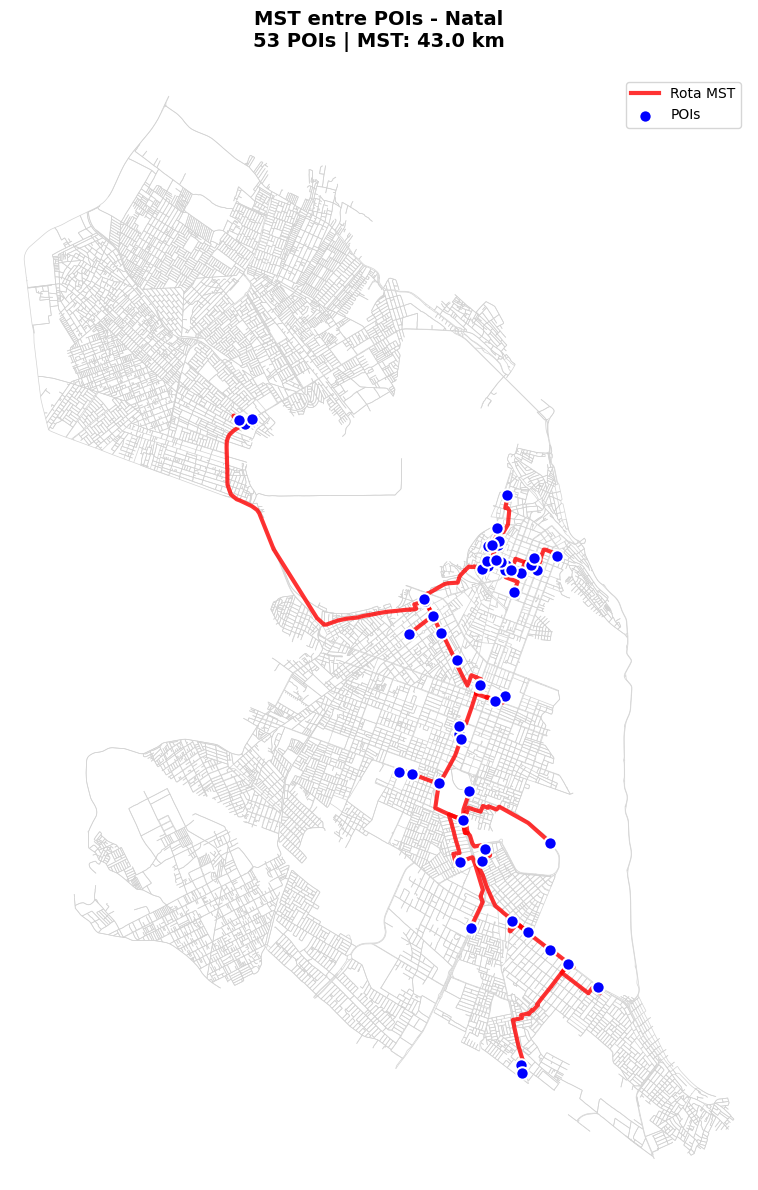

In [ ]:
# Plotar MST para Natal
if resultados_cidades:
    for resultado in resultados_cidades:
        if resultado['Cidade'].startswith('Natal'):
            print("Plotando: Natal")
            plotar_mst_cidade(resultado)
            break

Plotando: Belo Horizonte
Grafico salvo como: mst_Belo_Horizonte.png


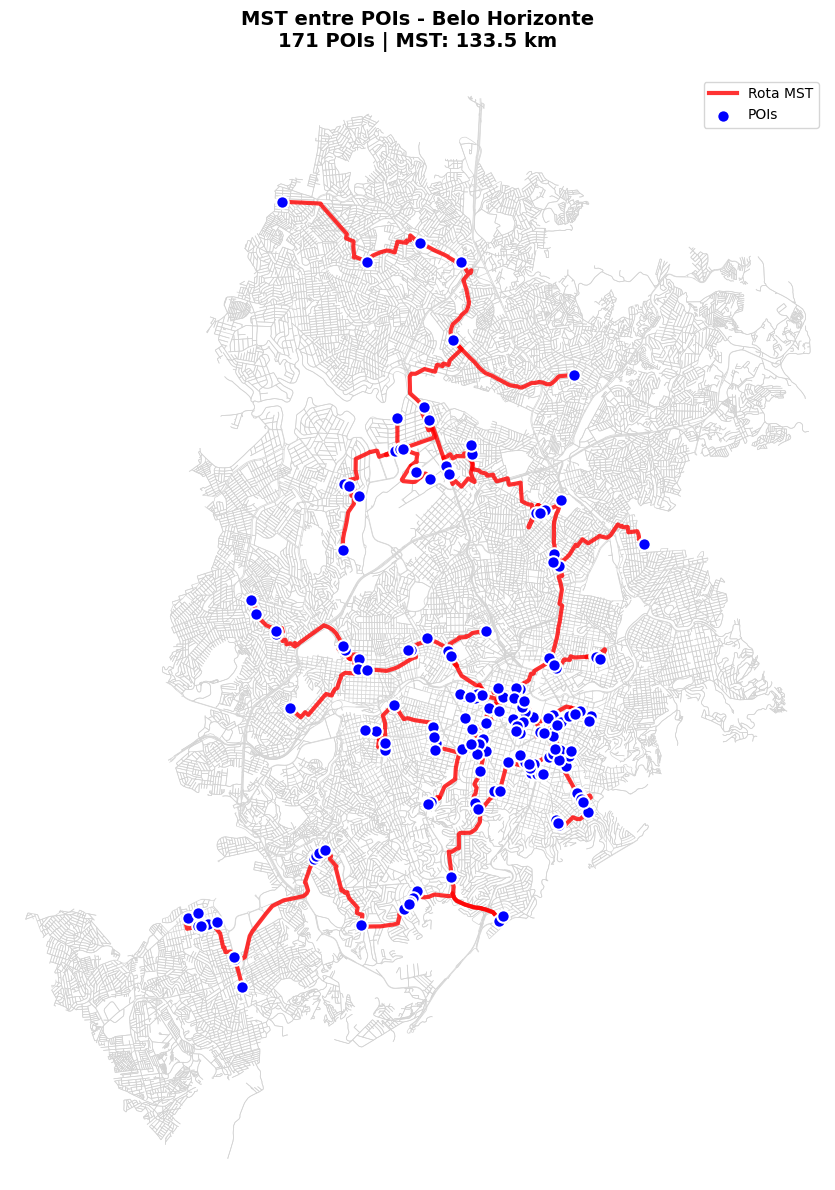

In [ ]:
# Plotar MST para Belo Horizonte
if resultados_cidades:
    for resultado in resultados_cidades:
        if resultado['Cidade'].startswith('Belo Horizonte'):
            print("Plotando: Belo Horizonte")
            plotar_mst_cidade(resultado)
            break

Plotando: Florianópolis
Grafico salvo como: mst_Florianópolis.png


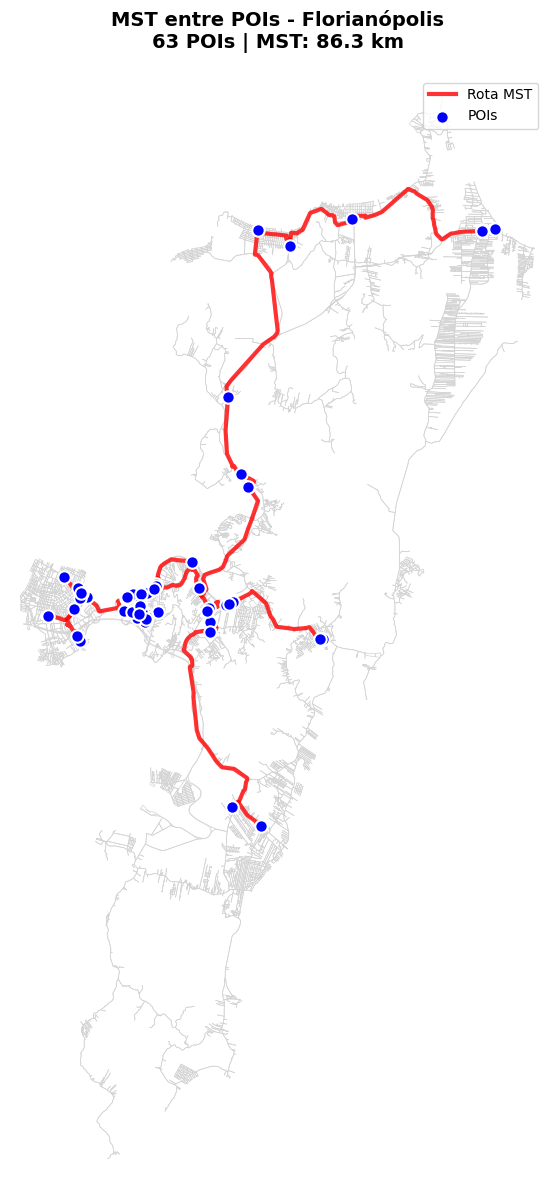

In [ ]:
# Plotar MST para Florianópolis
if resultados_cidades:
    for resultado in resultados_cidades:
        if resultado['Cidade'].startswith('Florianópolis'):
            print("Plotando: Florianópolis")
            plotar_mst_cidade(resultado)
            break

Plotando: Salvador
Grafico salvo como: mst_Salvador.png


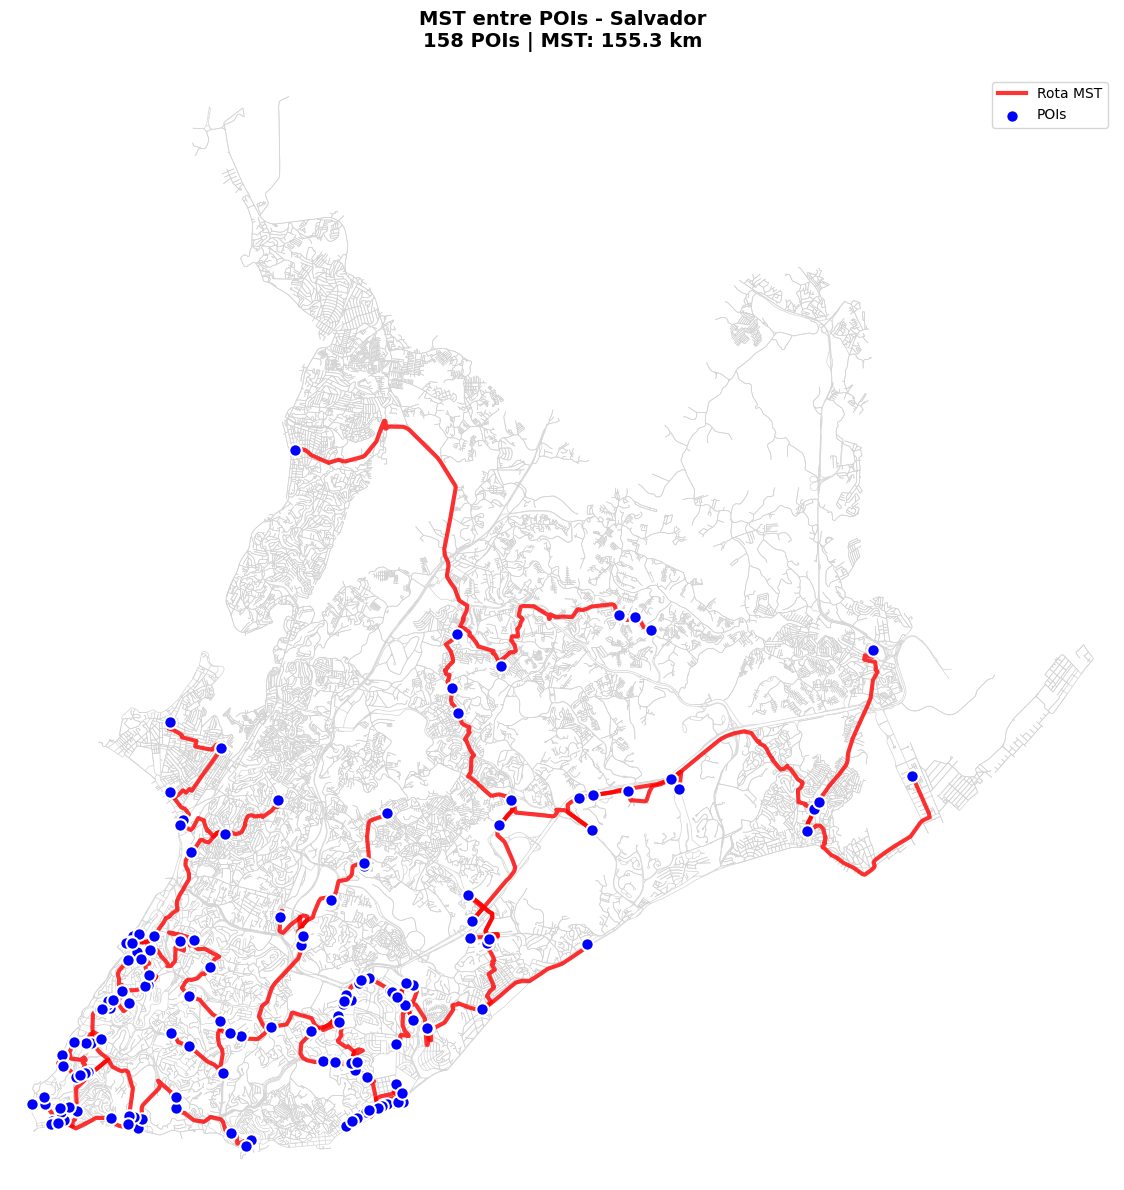

In [ ]:
# Plotar MST para Salvador
if resultados_cidades:
    for resultado in resultados_cidades:
        if resultado['Cidade'].startswith('Salvador'):
            print("Plotando: Salvador")
            plotar_mst_cidade(resultado)
            break

Plotando: João Pessoa
Grafico salvo como: mst_João_Pessoa.png


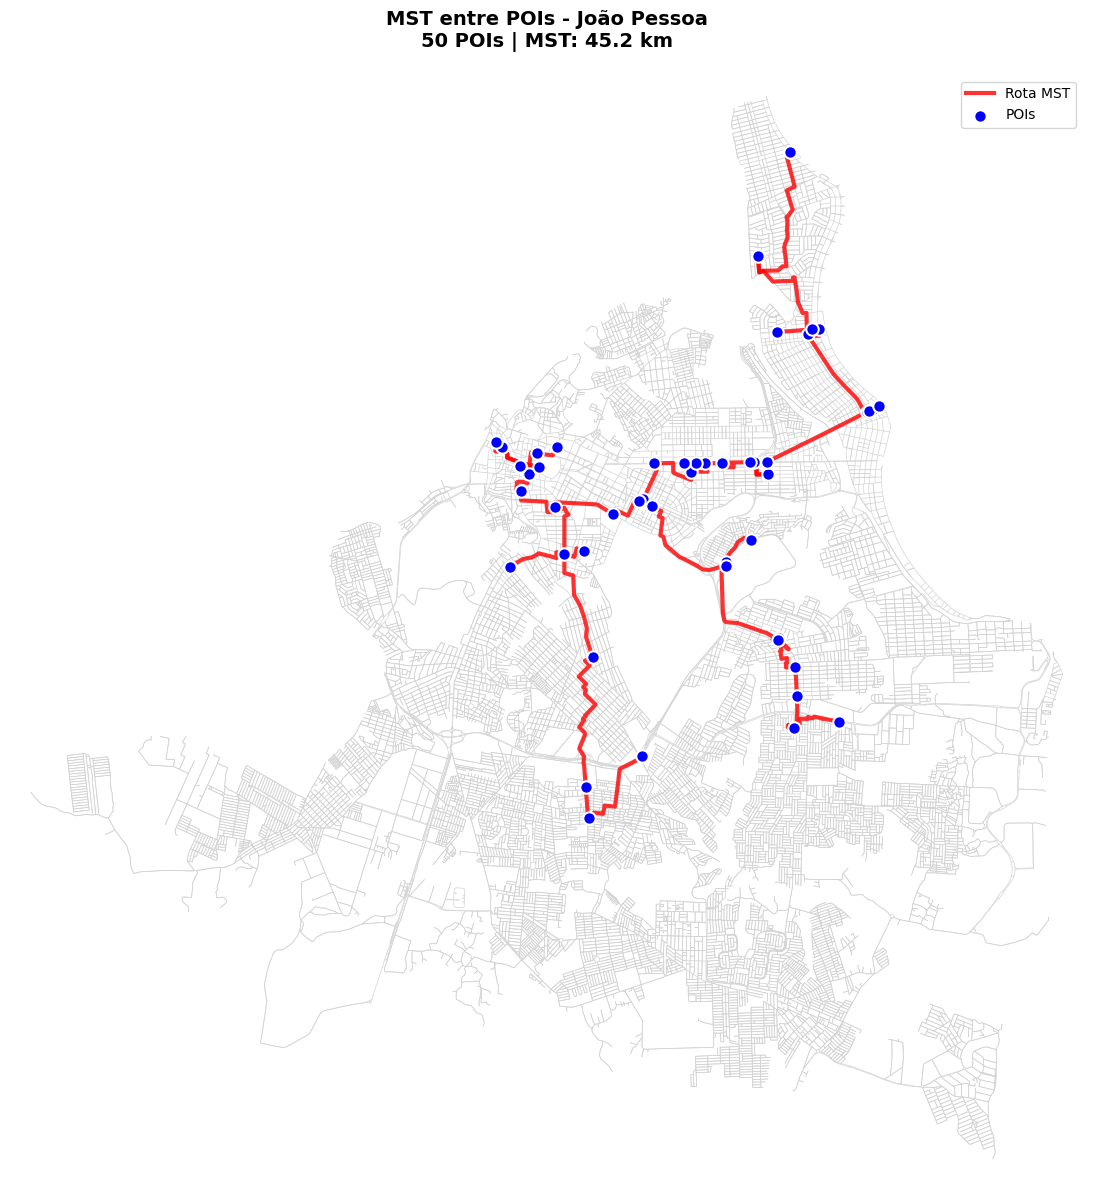

In [ ]:
# Plotar MST para João Pessoa
if resultados_cidades:
    for resultado in resultados_cidades:
        if resultado['Cidade'].startswith('João Pessoa'):
            print("Plotando: João Pessoa")
            plotar_mst_cidade(resultado)
            break

Plotando: Goiânia
Grafico salvo como: mst_Goiânia.png


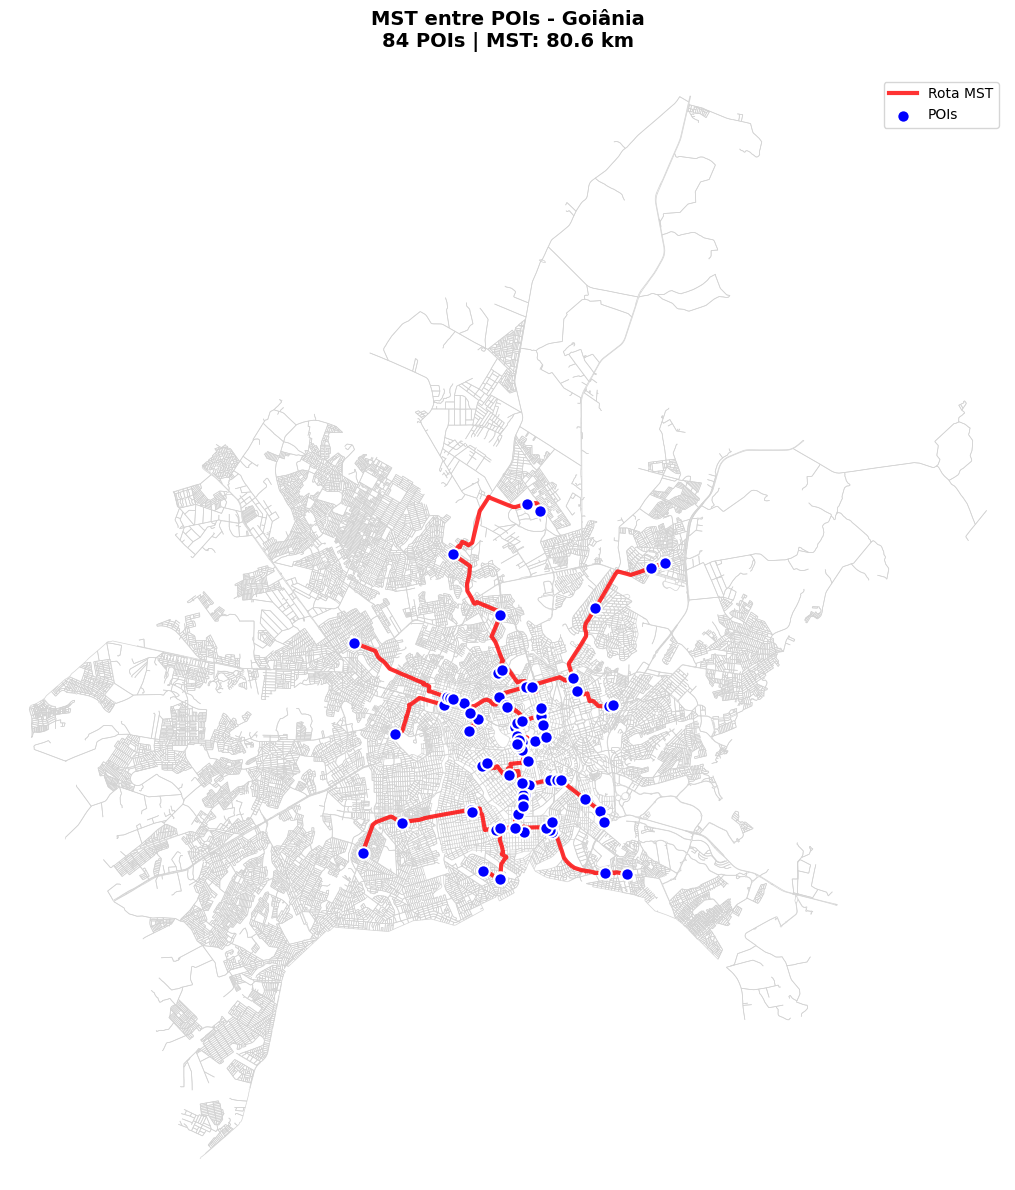

In [ ]:
# Plotar MST para Goiânia
if resultados_cidades:
    for resultado in resultados_cidades:
        if resultado['Cidade'].startswith('Goiânia'):
            print("Plotando: Goiânia")
            plotar_mst_cidade(resultado)
            break

Plotando: São Luís
Grafico salvo como: mst_São_Luís.png


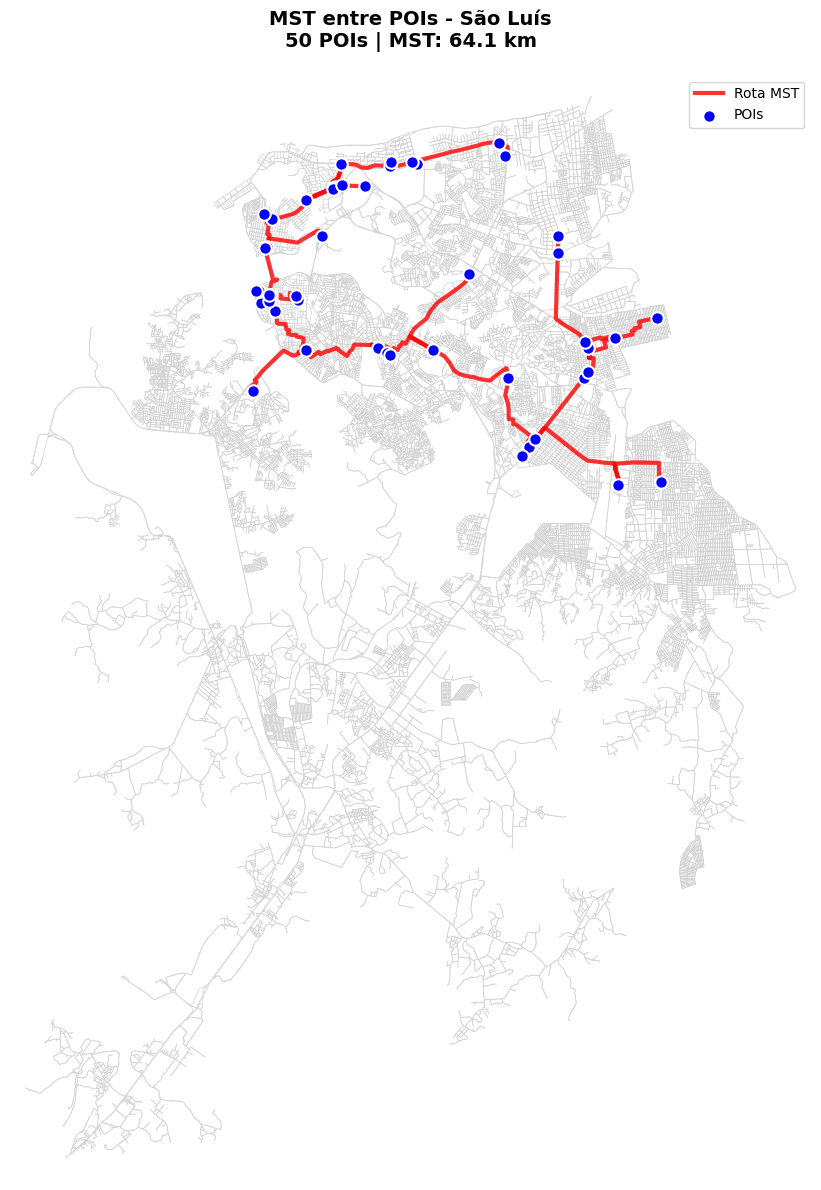

In [ ]:
# Plotar MST para São Luís
if resultados_cidades:
    for resultado in resultados_cidades:
        if resultado['Cidade'].startswith('São Luís'):
            print("Plotando: São Luís")
            plotar_mst_cidade(resultado)
            break

Plotando: Guarulhos
Grafico salvo como: mst_Guarulhos.png


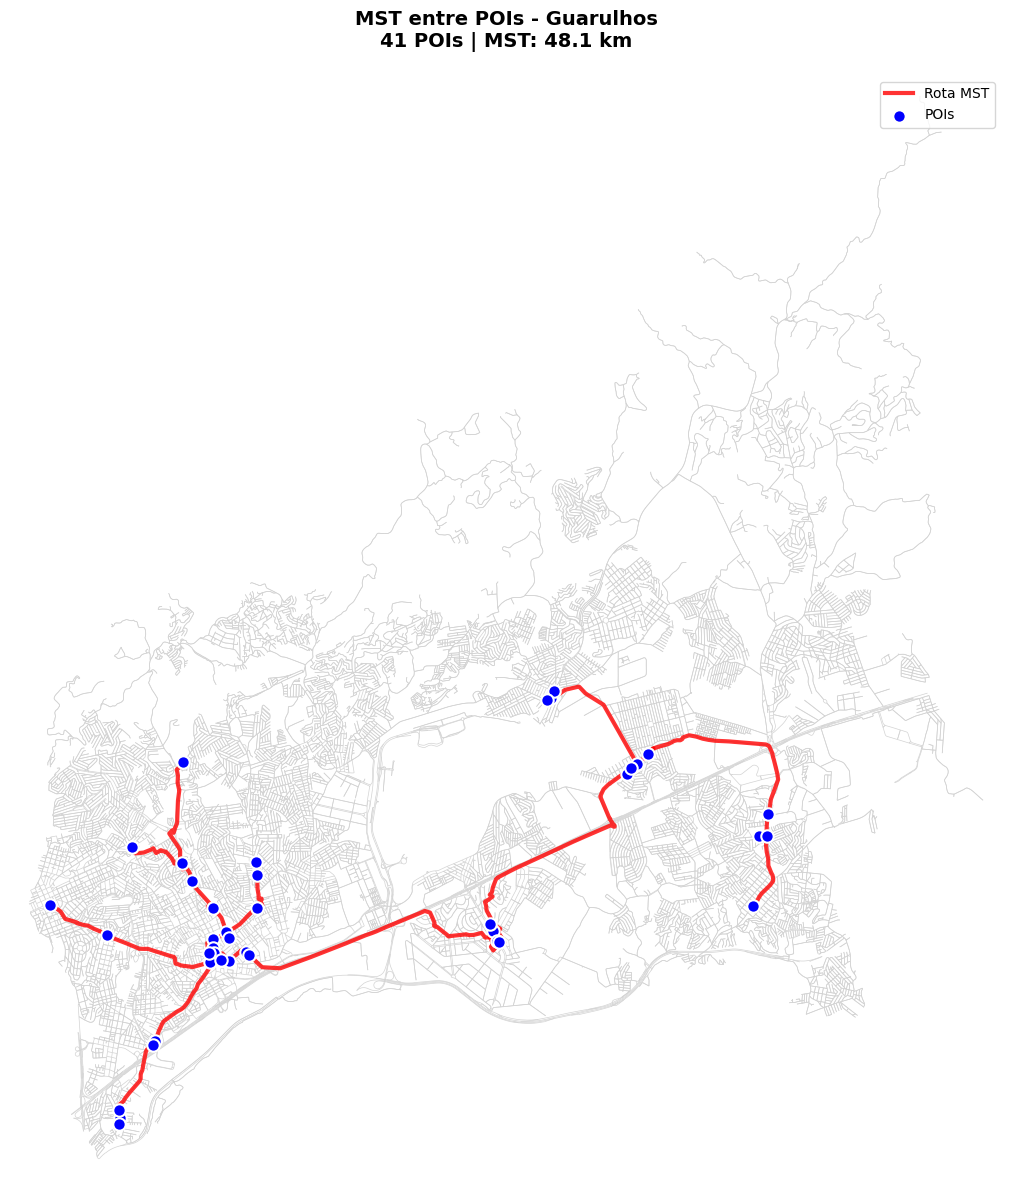

In [ ]:
# Plotar MST para Guarulhos
if resultados_cidades:
    for resultado in resultados_cidades:
        if resultado['Cidade'].startswith('Guarulhos'):
            print("Plotando: Guarulhos")
            plotar_mst_cidade(resultado)
            break

## 7. Análise Estatística

In [ ]:
# TABELA COMPARATIVA DETALHADA
print("\n" + "_" * 80)
print("TABELA COMPARATIVA CONSOLIDADA")
print("_" * 80)

if resultados_cidades:
    df_completo = pd.DataFrame(resultados_cidades)

    # Ordenar por comprimento da MST
    df_completo = df_completo.sort_values('MST_Real_km', ascending=False)

    # Criar tabela formatada
    tabela_comparativa = df_completo[[
        'Cidade', 'POIs_Encontrados', 'POIs_Unicos', 'MST_Real_km',
        'Media_por_POI_km', 'Media_por_Aresta_km', 'Arestas_MST'
    ]].copy()

    # Formatar nomes das cidades
    tabela_comparativa['Cidade'] = tabela_comparativa['Cidade'].apply(
        lambda x: x.split(',')[0]
    )

    # Renomear colunas
    tabela_comparativa.columns = [
        'Cidade', 'POIs Total', 'POIs Únicos', 'MST (km)',
        'Media por POI (km)', 'Media por Aresta (km)', 'Arestas MST'
    ]

    # Formatar números
    for col in ['MST (km)', 'Media por POI (km)', 'Media por Aresta (km)']:
        tabela_comparativa[col] = tabela_comparativa[col].round(2)

    print("\n" + tabela_comparativa.to_string(index=False))

    # ESTATÍSTICAS DETALHADAS
    print("\n" + "_" * 80)
    print("ESTATÍSTICAS DETALHADAS")
    print("_" * 80)

    stats_data = {
        'Metrica': [
            'Comprimento Total da MST',
            'Media por POI',
            'Media por Aresta MST',
            'POIs Únicos por Cidade',
            'Arestas MST por Cidade'
        ],
        'Media': [
            df_completo['MST_Real_km'].mean(),
            df_completo['Media_por_POI_km'].mean(),
            df_completo['Media_por_Aresta_km'].mean(),
            df_completo['POIs_Unicos'].mean(),
            df_completo['Arestas_MST'].mean()
        ],
        'Desvio Padrao': [
            df_completo['MST_Real_km'].std(),
            df_completo['Media_por_POI_km'].std(),
            df_completo['Media_por_Aresta_km'].std(),
            df_completo['POIs_Unicos'].std(),
            df_completo['Arestas_MST'].std()
        ],
        'Minimo': [
            df_completo['MST_Real_km'].min(),
            df_completo['Media_por_POI_km'].min(),
            df_completo['Media_por_Aresta_km'].min(),
            df_completo['POIs_Unicos'].min(),
            df_completo['Arestas_MST'].min()
        ],
        'Maximo': [
            df_completo['MST_Real_km'].max(),
            df_completo['Media_por_POI_km'].max(),
            df_completo['Media_por_Aresta_km'].max(),
            df_completo['POIs_Unicos'].max(),
            df_completo['Arestas_MST'].max()
        ]
    }

    df_stats = pd.DataFrame(stats_data)
    for col in ['Media', 'Desvio Padrao', 'Minimo', 'Maximo']:
        df_stats[col] = df_stats[col].round(2)

    print("\n" + df_stats.to_string(index=False))

    # ANÁLISE COMPARATIVA
    print("\n" + "_" * 80)
    print("ANALISE COMPARATIVA")
    print("_" * 80)

    maior_mst = df_completo.iloc[0]
    menor_mst = df_completo.iloc[-1]

    maior_eficiencia = df_completo.loc[df_completo['Media_por_POI_km'].idxmin()]
    menor_eficiencia = df_completo.loc[df_completo['Media_por_POI_km'].idxmax()]

    print(f"\nDESTAQUES:")
    print(f"Maior MST: {maior_mst['Cidade'].split(',')[0]} ({maior_mst['MST_Real_km']:.1f} km)")
    print(f"Menor MST: {menor_mst['Cidade'].split(',')[0]} ({menor_mst['MST_Real_km']:.1f} km)")
    print(f"Mais eficiente: {maior_eficiencia['Cidade'].split(',')[0]} ({maior_eficiencia['Media_por_POI_km']:.2f} km/POI)")
    print(f"Menos eficiente: {menor_eficiencia['Cidade'].split(',')[0]} ({menor_eficiencia['Media_por_POI_km']:.2f} km/POI)")


________________________________________________________________________________
TABELA COMPARATIVA CONSOLIDADA
________________________________________________________________________________

        Cidade  POIs Total  POIs Únicos  MST (km)  Media por POI (km)  Media por Aresta (km)  Arestas MST
      Salvador         185          158    155.25                0.98                   0.99          157
Belo Horizonte         205          171    133.49                0.78                   0.79          170
 Florianópolis          73           63     86.33                1.37                   1.39           62
       Goiânia          96           84     80.60                0.96                   0.97           83
      São Luís          51           50     64.13                1.28                   1.31           49
     Guarulhos          47           41     48.12                1.17                   1.20           40
   João Pessoa          53           50     45.20              

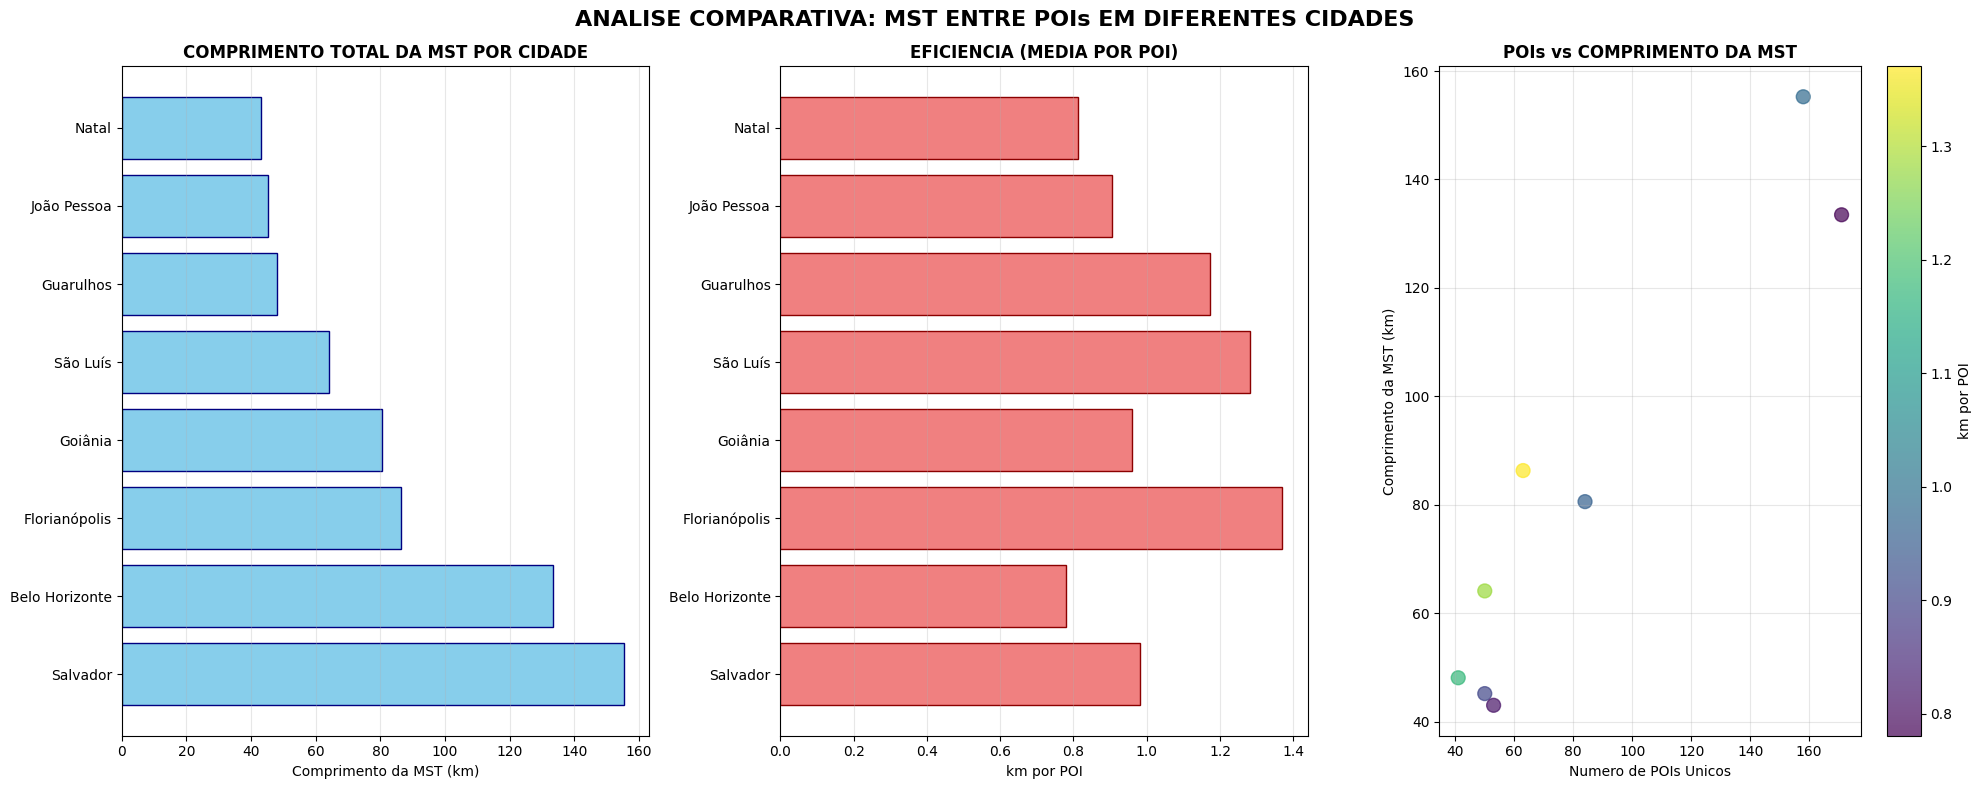

Analise completa gerada e salva como 'analise_comparativa_final.png'


In [ ]:
if resultados_cidades:
    # GRÁFICO COMPARATIVO FINAL
    # Modificando a estrutura dos subplots para 1 linha e 3 colunas
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8)) # Ajustando figsize

    # Gráfico 1: MST por cidade
    cidades_curtas = [c.split(',')[0] for c in df_completo['Cidade']]
    ax1.barh(cidades_curtas, df_completo['MST_Real_km'], color='skyblue', edgecolor='navy')
    ax1.set_xlabel('Comprimento da MST (km)')
    ax1.set_title('COMPRIMENTO TOTAL DA MST POR CIDADE', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Gráfico 2: Eficiência por POI
    ax2.barh(cidades_curtas, df_completo['Media_por_POI_km'], color='lightcoral', edgecolor='darkred')
    ax2.set_xlabel('km por POI')
    ax2.set_title('EFICIENCIA (MEDIA POR POI)', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # Gráfico 3: POIs únicos vs MST
    scatter = ax3.scatter(df_completo['POIs_Unicos'], df_completo['MST_Real_km'],
                         s=100, alpha=0.7, c=df_completo['Media_por_POI_km'],
                         cmap='viridis')
    ax3.set_xlabel('Numero de POIs Unicos')
    ax3.set_ylabel('Comprimento da MST (km)')
    ax3.set_title('POIs vs COMPRIMENTO DA MST', fontweight='bold')
    plt.colorbar(scatter, ax=ax3, label='km por POI')
    ax3.grid(alpha=0.3)

    plt.suptitle('ANALISE COMPARATIVA: MST ENTRE POIs EM DIFERENTES CIDADES',
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('analise_comparativa_final.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Analise completa gerada e salva como 'analise_comparativa_final.png'")

else:
    print("Nenhum resultado disponivel para analise")

## **Análise Crítica dos Resultados Obtidos**

Com base na análise realizada, a aplicação conjunta dos algoritmos A* e da Árvore Geradora Mínima (MST) proporcionou uma avaliação abrangente da eficiência de conectividade entre os Pontos de Interesse (POIs) nas cidades estudadas. Enquanto a MST quantifica a infraestrutura mínima necessária para interligar todos os pontos, o A* permite estimar a eficiência das rotas específicas entre pares de POIs, considerando as restrições reais da malha urbana.

Os resultados evidenciam padrões distintos. Florianópolis e Goiás, com valores reduzidos de MST por POI (0,2 km), indicam uma distribuição espacial compacta e sugerem rotas A* curtas e diretas, refletindo uma estrutura urbana altamente eficiente. Em contraste, São Luís e Guarulhos apresentam os maiores índices (1,3 km e 1,1 km por POI, respectivamente), o que aponta para rotas A* mais extensas e complexas, revelando desafios de conectividade que impactam tanto o planejamento estratégico quanto a mobilidade cotidiana.

A relação entre o comprimento da MST e o número de POIs varia significativamente entre os municípios. Salvador, por exemplo, possui uma MST extensa (152,8 km), o que implica em rotas A* igualmente longas para conectar POIs dispersos, característica de uma mancha urbana ampla. Por outro lado, Natal e João Pessoa, com MSTs mais curtas, sugerem trajetos A* naturalmente mais eficientes e concentrados.

Essa abordagem integrada demonstra o valor da combinação entre MST e A*: enquanto a MST orienta decisões estratégicas sobre infraestrutura urbana, o A contribui para a otimização operacional das rotas. Juntas, essas ferramentas oferecem uma visão robusta e complementar da acessibilidade urbana, essencial para o planejamento inteligente de cidades.